In [30]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pylab
%matplotlib inline
from collections import Counter
from nltk import pos_tag, word_tokenize, classify, bigrams, trigrams
from nltk.corpus import stopwords as stpwds
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

In [31]:
edmunds = pd.read_csv("C:\\Users\\Owner\\Desktop\\Python\\Assignment 3 Edmunds Posts.csv")
senti = pd.read_csv("C:\\Users\\Owner\\Desktop\\Python\\SentScores.csv")

# Part A

In [32]:
nodes = list(senti.columns.values)

In [37]:
#create dictionary out of sales for each car brand
CarSales = {'A6': 20000, 'A8':12000, '3-Series':220000, '5-Series': 60000, 
            '7-Series':14000,'XJ': 6600, 'ES':135000, 'LS':30000, 'RX': 120000, 'S-Class':25000}

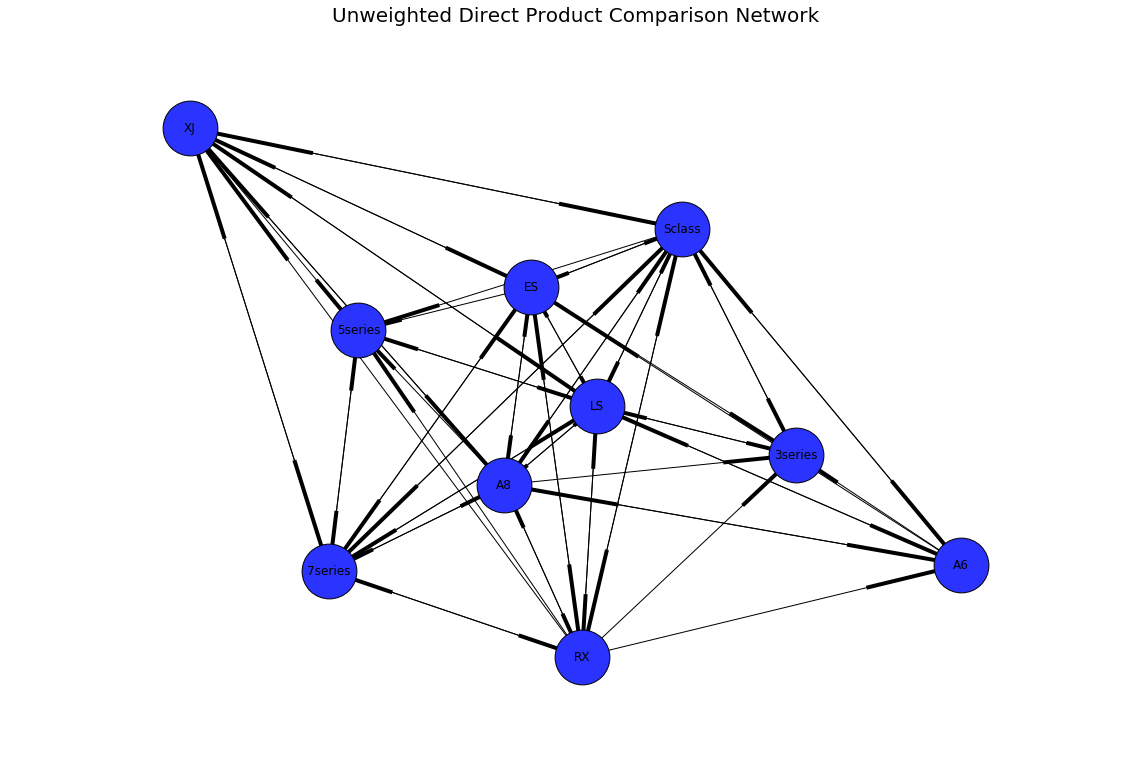

In [34]:
DG = nx.DiGraph()
for i in range(len(senti)):
    for x in senti.columns.values:
        if senti.ix[i][x] > 0:
            for y in senti.columns.values:
                if senti.ix[i][y] > 0:
                    if senti.ix[i][x] > senti.ix[i][y]:
                        if (x,y) not in DG.edges():
                            DG.add_edges_from([(x,y)])

# Create plot

plt.figure(figsize=(15,10))

pos=nx.spring_layout(DG)
nx.draw(DG,pos,node_color = [50/300., 200/1000., 250/250.], node_size=3000)
node_labels = {node:node for node in DG.nodes()}
nx.draw_networkx_labels(DG, pos, labels=node_labels)

plt.title("Unweighted Direct Product Comparison Network", fontsize=20)

pylab.show()

# Part B

Unweighted Pagerank Scores

In [36]:
unweighted_pr = [(key, round(nx.pagerank(DG, alpha=0.9, max_iter=1000)[key],3)) for key in nx.pagerank(DG, alpha=0.9, max_iter=1000)]
sorted(unweighted_pr, key=lambda tup:tup[1], reverse=True)

[('LS', 0.167),
 ('Sclass', 0.128),
 ('7series', 0.123),
 ('5series', 0.096),
 ('A8', 0.096),
 ('ES', 0.095),
 ('XJ', 0.083),
 ('3series', 0.078),
 ('RX', 0.076),
 ('A6', 0.057)]

Unweighted Pagerank correlations

In [38]:
#make dict out of list of tuples from pr scores
carPRscore = dict(unweighted_pr)

keys = list(carPRscore.viewkeys() | CarSales.viewkeys())
y=0
while (y < 11):
    print keys[y], np.corrcoef([carPRscore.get(x, y) for x in keys], [CarSales.get(x, y) for x in keys])[0,1]
    y+=1

XJ -0.345699307055
S-Class 0.326648853604
Sclass 0.330796040557
3-Series 0.332011537303
7series 0.332590471435
RX 0.332928556847
7-Series 0.333149871959
5series 0.333305768675
A6 0.333421341154
A8 0.333510305088
3series 0.333580789797


# Weighted Pagerank

In [5]:
col = senti.columns
ar = []
for i in range(len(col)-1):
    for j in range(len(col)):
        if j>i:
            pos = senti[[col[i],col[j]]][(senti[col[i]]>senti[col[j]])]
            neg = senti[[col[i],col[j]]][senti[col[i]]<senti[col[j]]]
            posv = (pos[col[i]]-pos[col[j]]).sum()
            negv = (neg[col[j]]-neg[col[i]]).sum()
            sen = posv-negv
            ar.append((col[i],col[j],sen))

In [6]:
ar2=[]
for i in ar:
    if i[2]<0:
        ar2.append((i[1],i[0],-i[2]))
    else:
        ar2.append(i)
    

In [7]:
DG=nx.DiGraph()
DG.add_nodes_from(nodes)
DG.add_weighted_edges_from(ar2)

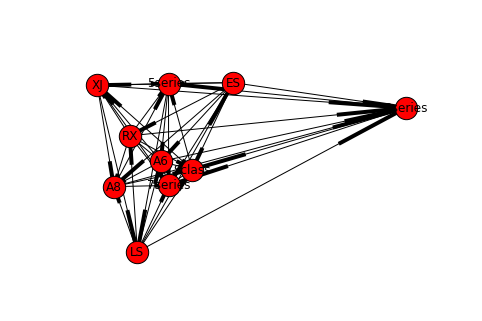

In [24]:
nx.draw(DG, with_labels=True, node_size=500)

get weighted pagerank scores

In [20]:
weighted_pr = [(key, round(nx.pagerank(DG, alpha=0.9, max_iter=1000)[key],3)) 
               for key in nx.pagerank(DG, alpha=0.9, max_iter=1000)]

sorted(weighted_pr, key=lambda tup:tup[1], reverse=True)

[('A6', 0.204),
 ('A8', 0.181),
 ('7series', 0.161),
 ('Sclass', 0.155),
 ('3series', 0.091),
 ('5series', 0.077),
 ('XJ', 0.06),
 ('LS', 0.043),
 ('RX', 0.014),
 ('ES', 0.014)]

calculate correlation between pagerank score and carsales

In [19]:
#make dict out of list of tuples from pr scores
carPRscore = dict(weighted_pr)

keys = list(carPRscore.viewkeys() | CarSales.viewkeys())
y=0
while (y < 11):
    print keys[y], np.corrcoef([carPRscore.get(x, y) for x in keys], [CarSales.get(x, y) for x in keys])[0,1]
    y+=1

XJ -0.531322130769
S-Class 0.274422658833
7series 0.30648202335
3-Series 0.316188793134
Sclass 0.320866208692
RX 0.323617104789
7-Series 0.325427876058
LS 0.326709815278
A6 0.327664867738
A8 0.328403777885
3series 0.3289923459


Pagerank takes into account the magnitude of the difference in sentiment between the car brands, so weighted pagerank gives us a better idea of precisely how much more preferred one car brand is over another